In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle as pkl
from pandas.core import base
s_path = os.path.dirname(os.path.realpath(__file__))
sys.path.append(s_path)
pd.set_option('display.max_columns',100)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import tm_teoriaMvto_base_prep as base_prep
import tm_teoriaMvto_ft_eng as ft_eng
from make_pickles import PipeX
# configuration for labeling and loading
path_files = os.path.join(s_path, 'historical_files')
# base prep control
EXPORT_X = True
EXPORT_Y = True
# params labeling
s_prefix = 'ft_'
s_lbl_type = 'regression'
f_th = 0.3
b_dist = True
b_percent = True
b_custom = False

In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\n

In [2]:
if EXPORT_X:
# df_data = base_prep.import_sampling(path_files= os.path.join(path_files, 'FeaturesFiles'),
#   prefix_files= s_prefix)
df_data = pd.read_csv(os.path.join(path_files, 'FeaturesFiles', 'AllFiles.csv')) #, index_col= 0, nrows=100000)
df_data.drop(columns='Unnamed: 0', inplace=True)
# create new features before extracting samples - using full data needed by lag features
df_data = ft_eng.BasicFeatures().transform(X=df_data)

In [3]:
if EXPORT_Y:
col_label = [ 'date_trd', 'update', 'time', 'trd_id', # IDX
'side', 'first_price', 'id_run', 's_run',
'max_run', 'flag_d', 'id_p', 'seq',
'chg_max', 'chg_max_mp', 'freq', 'model']
# specify df_data = None (default) to load pickle from s_path + 'y_prep_data.pkl'
df_y = df_data[col_label].copy()
label_type= s_lbl_type
b_dist_to_high= b_dist
prefix_files = s_prefix
th_label_y1=f_th
b_percent_freq=b_percent
b_custom_dir=b_custom
th = int(th_label_y1) if not b_percent_freq else (th_label_y1 * df_y['freq'])
# variables needed for label
df_y['run_high'] = df_y.groupby(['date_trd','id_run'])['max_run'].transform('last')
if b_custom_dir:
if b_dist_to_high:
run_sz = th * 2
else:
run_sz = th
df_y['d_run'] = df_y['run_high'].abs() >= run_sz
else:
df_y['d_run'] = df_y.groupby(['date_trd','id_run'])['flag_d'].transform('last')
m_same_p = ((df_y['s_run'] != 0) & ((df_y['chg_max'] == df_y['max_run']) |
(df_y['chg_max_mp'] == - df_y['max_run'])))
df_y.loc[m_same_p, 'id_first_p'] = df_y.loc[m_same_p, 'id_p']
m_first_p = (df_y['id_run'] > df_y['id_run'].shift()) & pd.isna(df_y['id_first_p'])
df_y.loc[m_first_p, 'id_first_p'] = df_y.loc[m_first_p, 'id_p']-2
df_first_p = df_y.loc[pd.notna(df_y['id_first_p']), ['date_trd', 'id_first_p', 'run_high']]
df_first_p.set_index(['date_trd', 'id_first_p'], inplace= True)
if df_first_p.index.duplicated().any():
df_first_p = df_first_p.loc[~df_first_p.index.duplicated(keep='first')]
# try to drop to prevent error in case of
# running multiple times
try:
df_y.drop(columns=['run_high_dir'], inplace=True)
except KeyError:
pass
# add _dir joining from first P of the run
df_y = df_y.join(df_first_p, on=['date_trd','id_p'], rsuffix='_dir')
# set index to merge with X
df_y.set_index(['date_trd','update','time','trd_id'], inplace=True)

In [4]:
df_y['y'] = np.nan
# first: treat ideal start of the run (formal end of previous movement)
# df_y.loc[pd.notna(df_y['run_high_dir']) & pd.notna(df_y['model']), 'y'] = df_y['run_high_dir']
df_y.loc[pd.notna(df_y['run_high_dir']) & pd.notna(df_y['model']) , 'y'] = df_y['run_high_dir'] - df_y['chg_max']
lbl_run_high = pd.isna(df_y['y']) & pd.notna(df_y['model'])
# df_y.loc[lbl_run_high, 'y'] = df_y['run_high']
df_y.loc[lbl_run_high & (df_y['chg_max'].abs() >= df_y['chg_max_mp'].abs()), 'y'] = df_y['run_high'] - df_y['max_run']
df_y.loc[lbl_run_high & (df_y['chg_max'].abs() <  df_y['chg_max_mp'].abs()), 'y'] = df_y['run_high'] - (df_y['max_run'] + df_y['chg_max_mp'] + df_y['chg_max'])

In [5]:
# ignore first UPDATE
df_data = df_data.loc[(df_data['update'] != df_data.groupby('date_trd')['update'].transform('first'))]  # & pd.notna(df_data['model'])
df_data.set_index(['date_trd','update','time','trd_id'], inplace=True)
df_data = df_data.join(df_y[['y', 'run_high', 'run_high_dir', 'd_run']])

In [6]:
cols = dict()
df_X = df_data.rename(columns={'model': 'f_model'})
df_X = df_X.loc[pd.notna(df_X['f_model'])].filter(regex='f_')
for s in df_X.columns: cols[s] = s[2:]
df_X.rename(columns=cols, inplace=True)
prop_size = [2.5, 3.5, 4.5]
prop_exp = [2, 1.2, 0.8]
fade_ft = [0.5, 0.7, 0.9]
for size in prop_size:
for expn in prop_exp:
prop_bid = 'escora_bid_' + str(size) + '_' + str(expn)
prop_ask = 'escora_ask_' + str(size) + '_' + str(expn)
df_X[[prop_bid,prop_ask]] = df_X[[prop_bid,prop_ask]].fillna(1/(14**expn))
df_X['escora_DIF_' + str(size) + '_' + str(expn)] = df_X[prop_bid] - df_X[prop_ask]
for fft in fade_ft:
prop_bid = 'movesc_bid_' + str(size) + '_' + str(fft)
prop_ask = 'movesc_ask_' + str(size) + '_' + str(fft)
df_X['movesc_DIF_' + str(size) + '_' + str(fft)] = df_X[prop_bid] - df_X[prop_ask]
df_X = ft_eng.DifAll().transform(X=df_X)
df_X.head()

vol_trd  n_trd  vol_big  n_big  \
date_trd   update time            trd_id                                   
2020-06-01 37220  09:15:21.637000 333        3430    334     1280     41   
           37983  09:15:51.050000 357        3605    358     1305     42   
           38065  09:15:51.100000 362        3655    363     1305     42   
           39996  09:16:29.972000 430        4110    431     1360     44   
           40985  09:17:03.888000 458         245     32       45      2   

                                          vol_big_ratio  big_c  big_v  \
date_trd   update time            trd_id                                
2020-06-01 37220  09:15:21.637000 333             0.373    735    545   
           37983  09:15:51.050000 357             0.362    735    570   
           38065  09:15:51.100000 362             0.357    735    570   
           39996  09:16:29.972000 430             0.331    755    605   
           40985  09:17:03.888000 458             0.184     45      0   

                                          aggpior_c  aggpior_v  aggimb  \
date_trd   update time            trd_id                                 
2020-06-01 37220  09:15:21.637000 333             0         50   0.006   
           37983  09:15:51.050000 357             0          0   0.012   
           38065  09:15:51.100000 362             0          0   0.010   
           39996  09:16:29.972000 430            20          0   0.019   
           40985  09:17:03.888000 458             0          0   0.143   

                                          aggimb_big  n_aggimb  agg_net_m  \
date_trd   update time            trd_id                                    
2020-06-01 37220  09:15:21.637000 333          0.148    -0.009         20   
           37983  09:15:51.050000 357          0.126    -0.011         45   
           38065  09:15:51.100000 362          0.126    -0.011         35   
           39996  09:16:29.972000 430          0.110    -0.009         80   
           40985  09:17:03.888000 458          1.000     0.062         35   

                                          aggbig_net_m  loc_aggbig_c_m  \
date_trd   update time            trd_id                                 
2020-06-01 37220  09:15:21.637000 333              190           5.881   
           37983  09:15:51.050000 357              165           6.244   
           38065  09:15:51.100000 362              165           5.388   
           39996  09:16:29.972000 430              150           2.133   
           40985  09:17:03.888000 458               45           3.157   

                                          loc_aggbig_v_m  loc_agg_net_m  \
date_trd   update time            trd_id                                  
2020-06-01 37220  09:15:21.637000 333              5.335        -23.948   
           37983  09:15:51.050000 357              5.371        198.754   
           38065  09:15:51.100000 362              5.154         83.400   
           39996  09:16:29.972000 430              2.980         18.821   
           40985  09:17:03.888000 458              0.000         21.202   

                                          loc_aggbig_net_m  loc_agg_imb_m  \
date_trd   update time            trd_id                                    
2020-06-01 37220  09:15:21.637000 333              150.771         -0.017   
           37983  09:15:51.050000 357              299.637          0.105   
           38065  09:15:51.100000 362               45.752          0.068   
           39996  09:16:29.972000 430              -11.250          0.103   
           40985  09:17:03.888000 458               23.496          0.143   

                                          loc_aggbig_imb_m  pagg_c_best  \
date_trd   update time            trd_id                                  
2020-06-01 37220  09:15:21.637000 333                0.267            0   
           37983  09:15:51.050000 357                0.411            1   
           38065  09:15:51.100000 362                

In [7]:
#  modelos AI
l_models=['mi_up','mi_down','mw_up','mw_down']
l_models_not_ready=['md_up', 'md_down']
d_pipes = {}
d_models = {}
d_th_prob = {}
for mdl_name in l_models:
file_to_store = open(os.path.join(s_path, 'pipe_' + mdl_name + ".pickle"), "rb")
d_pipes[mdl_name] = pkl.load(file_to_store)
obj_clf, threshold = d_pipes[mdl_name].get_model()  # ai_model, threshold
d_models[mdl_name] = obj_clf
d_th_prob[mdl_name] = threshold
file_to_store.close()
for mdl_name in l_models_not_ready:
d_th_prob[mdl_name] = 0.5

In [8]:
d_y_hat = {}
df_y_hat = pd.DataFrame()
for model in l_models:
df_X_aux = d_pipes[model].transform(df_X.loc[df_X['model'] == model])
y_hat = d_models[model].predict_proba(df_X_aux)[:,1]
d_y_hat[model] = pd.DataFrame(y_hat, index=df_X_aux.index)
df_y_hat = df_y_hat.append(d_y_hat[model])
df_X['y_hat'] = df_y_hat

In [9]:
l_columns_intro_sample = [ #  "update", "time",  IDX
"side", "avg_price", "qty",
"chg_cum", "chg_max", "id_p", "first_price",
"last_price", "flag_big", "chg_max_mp", "seq",
"s_run", "id_run", "max_run", "flag_d",
"freq", "model", "y", "run_high", "run_high_dir", "d_run",
# "best_bid", "best_ask", "f_depth_"
]
base_main = df_data[l_columns_intro_sample].copy()
base_main["prob"] = df_X["y_hat"]

In [10]:
spread = 0.5
gain = [2, 3.5, 4, 4.5, 5, 6, 7, 8]
stop = [-2, -3.5, -4, -4.5, -5, -6, -7, -8]
# TODO: filtro pelo TH de cada modelo - using optimum th from pickle files
# TODO: filtro por limit/market - using market por now
for model in ['mi_up','mw_up']:
base_main.loc[(base_main['model']==model) & (base_main['prob'] >= d_th_prob[model]),'position'] = 5
base_main.loc[(base_main['model']==model) & (base_main['side']=='+'),'entry_price'] = base_main['first_price']
base_main.loc[(base_main['model']==model) & (base_main['side']=='-'),'entry_price'] = base_main['first_price'] + spread
for model in ['mi_down','mw_down']:
base_main.loc[(base_main['model']==model) & (base_main['prob'] >= d_th_prob[model]),'position'] = -5
base_main.loc[(base_main['model']==model) & (base_main['side']=='+'),'entry_price'] = base_main['first_price'] - spread
base_main.loc[(base_main['model']==model) & (base_main['side']=='-'),'entry_price'] = base_main['first_price']

In [12]:
tN = 5  # trades
base_main['price_tN'] = base_main['avg_price'].shift(-tN)

In [14]:
base_main.head(20)

side  avg_price  qty  chg_cum  \
date_trd   update time            trd_id                                 
2020-06-01 36914  09:15:00.886000 325       -   5338.000   50   -3.500   
                  09:15:00.888000 326       -   5338.000    5   -3.500   
                  09:15:00.891000 327       -   5337.500    5   -4.000   
           36934  09:15:00.951000 328       -   5337.000    5   -4.500   
           36983  09:15:07.508000 329       -   5336.500    5   -5.000   
           37071  09:15:12.717000 330       +   5337.500   10   -4.000   
                  09:15:12.719000 331       +   5337.500   10   -4.000   
           37173  09:15:16.387000 332       -   5337.500   15   -4.000   
           37220  09:15:21.637000 333       +   5338.500    5    2.000   
           37279  09:15:24.510000 334       -   5338.000   25    1.500   
           37337  09:15:27.670000 335       +   5339.500    5    3.000   
           37368  09:15:27.840000 336       +   5339.500    5    3.000   
                  09:15:27.854000 337       -   5339.000   10    2.500   
           37391  09:15:28.753000 338       +   5339.000   15    2.500   
                  09:15:28.754000 339       +   5339.000    5    2.500   
           37436  09:15:31.328000 340       +   5338.500    5    2.000   
           37448  09:15:32.857000 341       +   5338.500    5    2.000   
           37476  09:15:36.157000 342       +   5338.500    5    2.000   
           37516  09:15:37.910000 343       -   5338.000   10    1.500   
           37629  09:15:44.793000 344       +   5338.500    5    2.000   

                                          chg_max  id_p  first_price  \
date_trd   update time            trd_id                               
2020-06-01 36914  09:15:00.886000 325      -3.500    24     5338.000   
                  09:15:00.888000 326      -3.500    24     5338.000   
                  09:15:00.891000 327      -4.000    24     5337.500   
           36934  09:15:00.951000 328      -4.500    24     5337.000   
           36983  09:15:07.508000 329      -5.000    24     5336.500   
           37071  09:15:12.717000 330      -5.000    24     5337.500   
                  09:15:12.719000 331      -5.000    24     5337.500   
           37173  09:15:16.387000 332      -5.000    24     5337.500   
           37220  09:15:21.637000 333       2.000    25     5338.500   
           37279  09:15:24.510000 334       2.000    25     5338.000   
           37337  09:15:27.670000 335       3.000    25     5339.500   
           37368  09:15:27.840000 336       3.000    25     5339.500   
                  09:15:27.854000 337       3.000    25     5339.000   
           37391  09:15:28.753000 338       3.000    25     5339.000   
                  09:15:28.754000 339       3.000    25     5339.000   
           37436  09:15:31.328000 340       3.000    25     5338.500   
           37448  09:15:32.857000 341       3.000    25     5338.500   
           37476  09:15:36.157000 342       3.000    25     5338.500   
           37516  09:15:37.910000 343       3.000    25     5338.000   
           37629  09:15:44.793000 344       3.000    25     5338.500   

                                          last_price  flag_big  chg_max_mp  \
date_trd   update time            trd_id                                     
2020-06-01 36914  09:15:00.886000 325       5338.000         1       4.000   
                  09:15:00.888000 326       5338.000         0       4.000   
                  09:15:00.891000 327       5337.500         0       4.000   
           36934  09:15:00.951000 328       5337.000         0       4.000   
           36983  09:15:07.508000 329       5336.500         0       4.000   
           37071  09:15:12.717000 330       5337.500         0       4.000   
                  09:15:12.719000 331       5337.500         0       4.000   
           37173  09:15:16.387000 332       5337.500         0       4.000   
           37220  09:15:21.637000 333       533

In [15]:
tN = 5  # trades
base_main['price_tN'] = base_main['avg_price'].shift(-tN) - base_main['avg_price']

In [20]:
delta_price[tN].loc[delta_price[tN] > 50]

date_trd    update  time             trd_id
2020-06-01  763104  15:04:34.175000  17425     99.108
                                     17426     55.388
                                     17466    149.156
2020-06-26  412943  11:18:10.025000  10133     86.643
                                     10143    126.492
2020-08-21  594875  12:58:26.304000  12249     77.205
2021-02-09  743407  15:00:41.353000  20303     52.500
                                     20310     60.905
Name: avg_price, dtype: float64

In [21]:
base_main.loc[('2020-06-01')].tail()

side  avg_price  qty  chg_cum  chg_max  id_p  \
update time            trd_id                                                
849902 15:18:45.043000 20378     +   5405.000   10   -3.000   -3.500  1124   
       15:18:45.044000 20379     +   5405.000    5   -3.000   -3.500  1124   
850138 15:18:49.545000 20380     -   5403.500   10   -4.500   -4.500  1124   
       15:18:49.546000 20381     -   5403.500   20   -4.500   -4.500  1124   
850255 15:18:51.779000 20382     +   5404.500   20   -3.500   -4.500  1124   

                               first_price  last_price  flag_big  chg_max_mp  \
update time            trd_id                                                  
849902 15:18:45.043000 20378      5405.000    5405.000         0       4.000   
       15:18:45.044000 20379      5405.000    5405.000         0       4.000   
850138 15:18:49.545000 20380      5403.500    5403.500         0       4.000   
       15:18:49.546000 20381      5403.500    5403.500         1       4.000   
850255 15:18:51.779000 20382      5404.500    5404.500         1       4.000   

                               seq  s_run  id_run  max_run  flag_d   freq  \
update time            trd_id                                               
849902 15:18:45.043000 20378   999     -1     546   -6.000       0 12.000   
       15:18:45.044000 20379   999     -1     546   -6.000       0 12.000   
850138 15:18:49.545000 20380     0     -1     546   -6.500       0 12.000   
       15:18:49.546000 20381     0     -1     546   -6.500       0 12.000   
850255 15:18:51.779000 20382     0     -1     546   -6.500       0 12.000   

                              model   y  run_high  run_high_dir  d_run  prob  \
update time            trd_id                                                  
849902 15:18:45.043000 20378    NaN nan    -6.500           nan      0   nan   
       15:18:45.044000 20379    NaN nan    -6.500           nan      0   nan   
850138 15:18:49.545000 20380    NaN nan    -6.500           nan      0   nan   
       15:18:49.546000 20381    NaN nan    -6.500           nan      0   nan   
850255 15:18:51.779000 20382    NaN nan    -6.500           nan      0   nan   

                               position  entry_price  price_tN  
update time            trd_id                                   
849902 15:18:45.043000 20378        nan          nan   -73.500  
       15:18:45.044000 20379        nan          nan   -73.000  
850138 15:18:49.545000 20380        nan          nan   -71.000  
       15:18:49.546000 20381        nan          nan   -70.500  
850255 15:18:51.779000 20382        nan          nan   -71.000

In [22]:
base_main.loc[('2020-06-01'),'avg_price'].shift(-tN).tail(5)

update  time             trd_id
849902  15:18:45.043000  20378    nan
        15:18:45.044000  20379    nan
850138  15:18:49.545000  20380    nan
        15:18:49.546000  20381    nan
850255  15:18:51.779000  20382    nan
Name: avg_price, dtype: float64

In [23]:
base_main.loc[('2020-06-01'),'avg_price'].shift(-tN) - base_main.loc[('2020-06-01'),'avg_price']

update  time             trd_id
36914   09:15:00.886000  325      -0.500
        09:15:00.888000  326      -0.500
        09:15:00.891000  327       0.000
36934   09:15:00.951000  328       1.500
36983   09:15:07.508000  329       1.500
                                   ...  
849902  15:18:45.043000  20378       nan
        15:18:45.044000  20379       nan
850138  15:18:49.545000  20380       nan
        15:18:49.546000  20381       nan
850255  15:18:51.779000  20382       nan
Name: avg_price, Length: 20058, dtype: float64

In [29]:
delta_price[tN].describe()

count   3545282.000
mean         -0.000
std           0.987
min        -148.767
25%          -0.500
50%           0.000
75%           0.500
max         149.156
Name: avg_price, dtype: float64

<AxesSubplot:>

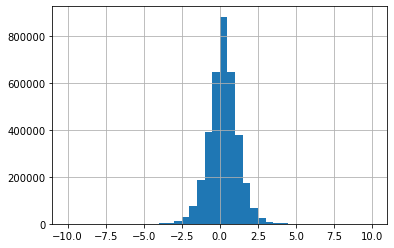

In [30]:
delta_price[tN].hist(bins=40, range=(-10, 10) )

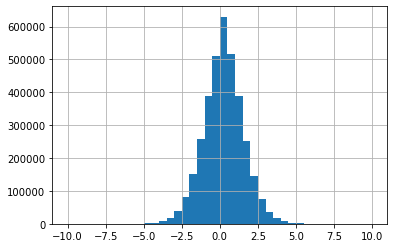

In [31]:
l_tempos = [10, ]  # trades
for tN in l_tempos:
delta_price[tN] = base_main.groupby(level=0)['avg_price'].shift(-tN) - base_main['avg_price']
delta_price[tN].describe()
rng = 0.1*delta_price[tN].max()
delta_price[tN].hist(bins=40, range=(-10, 10) )

In [32]:
print(delta_price[tN].describe())

count   3544317.000
mean         -0.000
std           1.336
min        -153.100
25%          -1.000
50%           0.000
75%           1.000
max         151.000
Name: avg_price, dtype: float64


In [33]:
0.987*np.sqrt(2)

1.395828786062245

count   3543352.000
mean         -0.001
std           1.613
min        -161.600
25%          -1.000
50%           0.000
75%           1.000
max         147.850
Name: avg_price, dtype: float64


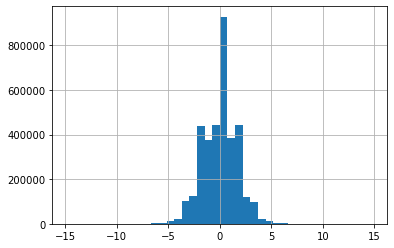

In [34]:
l_tempos = [15, ]  # trades
for tN in l_tempos:
delta_price[tN] = base_main.groupby(level=0)['avg_price'].shift(-tN) - base_main['avg_price']
print(delta_price[tN].describe())
rng = 0.1*delta_price[tN].max()
delta_price[tN].hist(bins=40, range=(-rng, rng) )

In [35]:
0.987*np.sqrt(3)

1.7095341470704817

In [36]:
1.336*np.sqrt(3/2)

1.6362591481791628

count   3542387.000
mean         -0.001
std           1.846
min        -161.850
25%          -1.000
50%           0.000
75%           1.000
max         151.600
Name: avg_price, dtype: float64


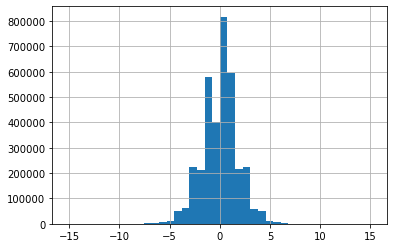

In [37]:
l_tempos = [20, ]  # trades
for tN in l_tempos:
delta_price[tN] = base_main.groupby(level=0)['avg_price'].shift(-tN) - base_main['avg_price']
print(delta_price[tN].describe())
rng = 0.1*delta_price[tN].max()
delta_price[tN].hist(bins=40, range=(-rng, rng) )

In [38]:
1.33*1.42

1.8886

In [39]:
base_main

side  avg_price  qty  chg_cum  \
date_trd   update time            trd_id                                 
2020-06-01 36914  09:15:00.886000 325       -   5338.000   50   -3.500   
                  09:15:00.888000 326       -   5338.000    5   -3.500   
                  09:15:00.891000 327       -   5337.500    5   -4.000   
           36934  09:15:00.951000 328       -   5337.000    5   -4.500   
           36983  09:15:07.508000 329       -   5336.500    5   -5.000   
...                                       ...        ...  ...      ...   
2021-03-30 801340 15:13:32.517000 14672     -   5727.000    5   -5.500   
           801525 15:13:48.442000 14673     +   5727.500    5   -5.000   
           801590 15:13:48.743000 14674     -   5726.000   10   -6.500   
                                  14675     -   5726.500   10   -6.000   
           801620 15:13:48.922000 14676     -   5725.500   10   -7.000   

                                          chg_max  id_p  first_price  \
date_trd   update time            trd_id                               
2020-06-01 36914  09:15:00.886000 325      -3.500    24     5338.000   
                  09:15:00.888000 326      -3.500    24     5338.000   
                  09:15:00.891000 327      -4.000    24     5337.500   
           36934  09:15:00.951000 328      -4.500    24     5337.000   
           36983  09:15:07.508000 329      -5.000    24     5336.500   
...                                           ...   ...          ...   
2021-03-30 801340 15:13:32.517000 14672    -5.500   615     5727.000   
           801525 15:13:48.442000 14673    -5.500   615     5727.500   
           801590 15:13:48.743000 14674    -6.500   615     5726.000   
                                  14675    -6.500   615     5726.500   
           801620 15:13:48.922000 14676    -7.000   615     5725.500   

                                          last_price  flag_big  chg_max_mp  \
date_trd   update time            trd_id                                     
2020-06-01 36914  09:15:00.886000 325       5338.000         1       4.000   
                  09:15:00.888000 326       5338.000         0       4.000   
                  09:15:00.891000 327       5337.500         0       4.000   
           36934  09:15:00.951000 328       5337.000         0       4.000   
           36983  09:15:07.508000 329       5336.500         0       4.000   
...                                              ...       ...         ...   
2021-03-30 801340 15:13:32.517000 14672     5727.000         0       3.500   
           801525 15:13:48.442000 14673     5727.500         0       3.500   
           801590 15:13:48.743000 14674     5726.000         0       3.500   
                                  14675     5726.500         0       3.500   
           801620 15:13:48.922000 14676     5725.500         0       3.500   

                                          seq  s_run  id_run  max_run  flag_d  \
date_trd   update time            trd_id                                        
2020-06-01 36914  09:15:00.886000 325     999      0      10    4.000       0   
                  09:15:00.888000 326     999      0      10    4.000       0   
                  09:15:00.891000 327     999      0      10   -4.000       0   
           36934  09:15:00.951000 328       0      0      10   -4.500       0   
           36983  09:15:07.508000 329      -1     -1      11   -5.000       0   
...                                       ...    ...     ...      ...     ...   
2021-03-30 801340 15:13:32.517000 14672    -1     -1     388   -5.500       0   
           801525 15:13:48.442000 14673    -1     -1     388   -5.500       0   
           801590 15:13:48.743000 14674    -1     -1     388   -6.500       1   
                                  14675    -1     -1     388   -6.500       1   
           801620 15:13:48.922000 14676    -1     -1     388   -7.000       1   

                                           freq model   y  run_high  \
d

In [40]:
base_main.loc[base_main['model']=='mw_up']

side  avg_price  qty  chg_cum  \
date_trd   update time            trd_id                                 
2020-06-01 37220  09:15:21.637000 333       +   5338.500    5    2.000   
           38065  09:15:51.100000 362       +   5342.000   10    2.000   
           40985  09:17:03.888000 458       +   5348.000   10    2.000   
           42270  09:17:55.831000 499       -   5348.500    5    2.000   
           43961  09:19:05.330000 576       +   5352.000    5    2.000   
...                                       ...        ...  ...      ...   
2021-03-30 768542 14:58:26.213000 13904     -   5742.500    5    2.000   
           770898 15:00:38.381000 13946     +   5742.000   20    3.000   
           792319 15:09:08.408000 14460     +   5726.500   20    3.500   
           792903 15:09:10.218000 14486     +   5724.500   10    2.000   
           795931 15:10:21.712000 14549     +   5724.500    5    2.000   

                                          chg_max  id_p  first_price  \
date_trd   update time            trd_id                               
2020-06-01 37220  09:15:21.637000 333       2.000    25     5338.500   
           38065  09:15:51.100000 362       2.000    27     5342.000   
           40985  09:17:03.888000 458       2.000    29     5348.000   
           42270  09:17:55.831000 499       2.000    31     5348.500   
           43961  09:19:05.330000 576       2.000    33     5352.000   
...                                           ...   ...          ...   
2021-03-30 768542 14:58:26.213000 13904     2.000   592     5742.500   
           770898 15:00:38.381000 13946     3.000   594     5742.000   
           792319 15:09:08.408000 14460     3.500   608     5726.500   
           792903 15:09:10.218000 14486     2.000   610     5724.500   
           795931 15:10:21.712000 14549     2.000   612     5724.500   

                                          last_price  flag_big  chg_max_mp  \
date_trd   update time            trd_id                                     
2020-06-01 37220  09:15:21.637000 333       5338.500         0      -5.000   
           38065  09:15:51.100000 362       5342.000         0      -2.500   
           40985  09:17:03.888000 458       5348.000         0      -5.000   
           42270  09:17:55.831000 499       5348.500         0      -2.500   
           43961  09:19:05.330000 576       5352.000         0      -2.000   
...                                              ...       ...         ...   
2021-03-30 768542 14:58:26.213000 13904     5742.500         0      -2.500   
           770898 15:00:38.381000 13946     5742.000         1      -3.500   
           792319 15:09:08.408000 14460     5726.500         1      -2.500   
           792903 15:09:10.218000 14486     5724.500         0      -4.000   
           795931 15:10:21.712000 14549     5724.500         0      -3.500   

                                          seq  s_run  id_run  max_run  flag_d  \
date_trd   update time            trd_id                                        
2020-06-01 37220  09:15:21.637000 333      -1     -1      11   -5.000       0   
           38065  09:15:51.100000 362     999      1      13    6.000       0   
           40985  09:17:03.888000 458     999      1      15    5.000       0   
           42270  09:17:55.831000 499       0     -1      16   -5.000       0   
           43961  09:19:05.330000 576       1      1      17    5.500       0   
...                                       ...    ...     ...      ...     ...   
2021-03-30 768542 14:58:26.213000 13904     0      0     373    2.000       0   
           770898 15:00:38.381000 13946   999     -1     374   -3.500       0   
           792319 15:09:08.408000 14460     1      1     384    3.500       0   
           792903 15:09:10.218000 14486   999      0     385   -4.000       0   
           795931 15:10:21.712000 14549     0      0     385   -3.500       0   

                                           freq  model      y  run_high 

In [41]:
model = 'mw_up'
base_entries = base_main.loc[base_main['model']==model]

In [42]:
linspace(5, 40, 5)

NameError: name 'linspace' is not defined

In [43]:
np.linspace(5, 40, 5)

array([ 5.  , 13.75, 22.5 , 31.25, 40.  ])

In [44]:
range(1,20) * 5

TypeError: unsupported operand type(s) for *: 'range' and 'int'

In [45]:
np.array(range(1,20)) * 5

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])

In [46]:
aa = np.array(range(1,20)) * 5

In [47]:
for i in aa:
print(aa)

[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 9

In [48]:
for i in aa:
print(i)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [49]:
delta_price = {}

count   43581.000
mean       -0.007
std         7.997
min       -53.000
25%        -4.500
50%         0.375
75%         4.688
max        35.250
Name: avg_price, dtype: float64
count   42616.000
mean       -0.021
std        11.267
min       -52.500
25%        -7.000
50%         0.500
75%         7.500
max        44.000
Name: avg_price, dtype: float64
count   41651.000
mean       -0.055
std        13.836
min       -62.800
25%        -9.000
50%         0.500
75%         9.333
max        51.500
Name: avg_price, dtype: float64
count   40686.000
mean       -0.094
std        16.000
min       -67.000
25%       -11.000
50%         0.500
75%        11.000
max        61.833
Name: avg_price, dtype: float64
count   39721.000
mean       -0.117
std        17.936
min       -76.500
25%       -12.000
50%         0.500
75%        12.167
max        67.500
Name: avg_price, dtype: float64
count   38756.000
mean       -0.122
std        19.642
min       -75.250
25%       -13.500
50%         0.500
75%        1

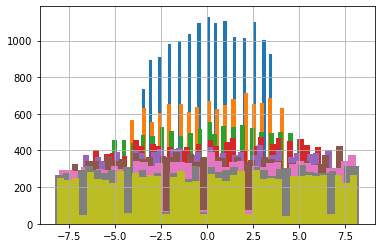

In [50]:
l_tempos = np.array(range(1,10)) * 5  # n trades
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.1*delta_price[tN].max()
delta_price[tN].hist(bins=40, range=(-rng, rng) )

count   43581.000
mean       -0.007
std         7.997
min       -53.000
25%        -4.500
50%         0.375
75%         4.688
max        35.250
Name: avg_price, dtype: float64


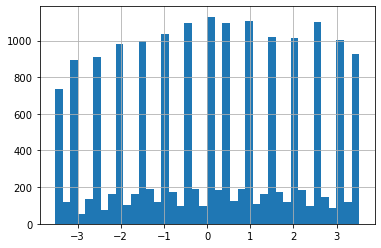

In [51]:
l_tempos = [5,]
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.1*delta_price[tN].max()
delta_price[tN].hist(bins=40, range=(-rng, rng) )

count   43581.000
mean       -0.007
std         7.997
min       -53.000
25%        -4.500
50%         0.375
75%         4.688
max        35.250
Name: avg_price, dtype: float64


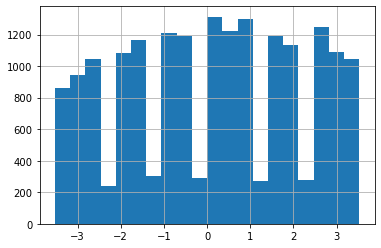

In [52]:
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.1*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

count   43581.000
mean       -0.007
std         7.997
min       -53.000
25%        -4.500
50%         0.375
75%         4.688
max        35.250
Name: avg_price, dtype: float64


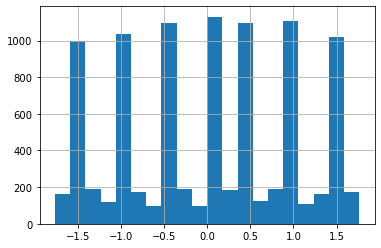

In [53]:
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.05*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

count   43581.000
mean       -0.007
std         7.997
min       -53.000
25%        -4.500
50%         0.375
75%         4.688
max        35.250
Name: avg_price, dtype: float64


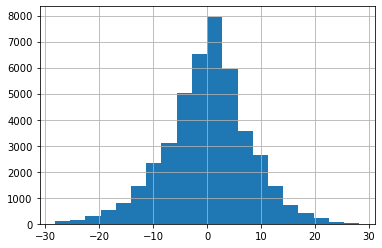

In [54]:
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.8*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

count   42616.000
mean       -0.021
std        11.267
min       -52.500
25%        -7.000
50%         0.500
75%         7.500
max        44.000
Name: avg_price, dtype: float64


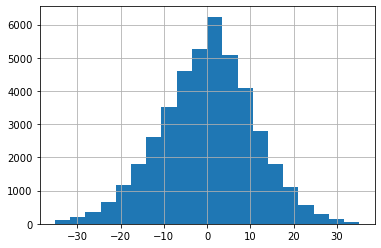

In [55]:
l_tempos = [10,]
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.8*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

In [56]:
8*np.sqrt(2)

11.313708498984761

count   41651.000
mean       -0.055
std        13.836
min       -62.800
25%        -9.000
50%         0.500
75%         9.333
max        51.500
Name: avg_price, dtype: float64


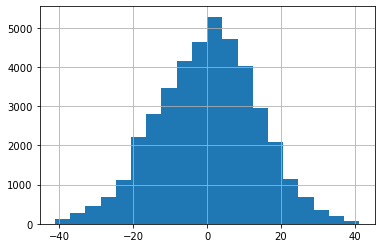

In [57]:
l_tempos = np.array(range(1,10)) * 5  # n trades
l_tempos = [15,]
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.8*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

In [58]:
8*np.sqrt(3)

13.856406460551018

count   40686.000
mean       -0.094
std        16.000
min       -67.000
25%       -11.000
50%         0.500
75%        11.000
max        61.833
Name: avg_price, dtype: float64


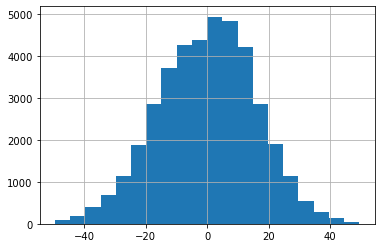

In [59]:
l_tempos = np.array(range(1,10)) * 5  # n trades
l_tempos = [20,]
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.8*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

count   39721.000
mean       -0.117
std        17.936
min       -76.500
25%       -12.000
50%         0.500
75%        12.167
max        67.500
Name: avg_price, dtype: float64


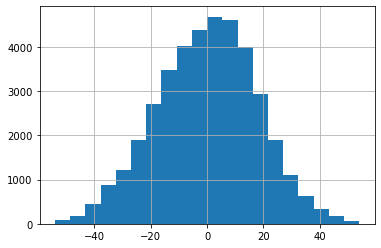

In [60]:
l_tempos = np.array(range(1,10)) * 5  # n trades
l_tempos = [25,]
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.8*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

count   29139.000
mean        0.230
std        32.942
min      -101.000
25%       -23.500
50%        -0.500
75%        23.500
max       118.500
Name: avg_price, dtype: float64


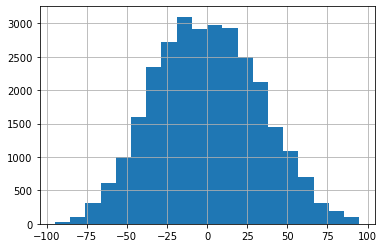

In [61]:
l_tempos = np.array(range(1,10)) * 5  # n trades
l_tempos = [80,]
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.8*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

count   36826.000
mean       -0.116
std        22.684
min       -80.833
25%       -16.000
50%         0.500
75%        15.500
max        82.500
Name: avg_price, dtype: float64


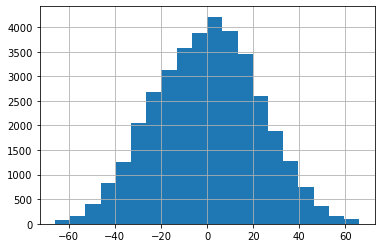

In [62]:
l_tempos = np.array(range(1,10)) * 5  # n trades
l_tempos = [40,]
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.8*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

count   34896.000
mean       -0.044
std        25.407
min       -88.650
25%       -18.500
50%         0.000
75%        17.750
max        83.000
Name: avg_price, dtype: float64


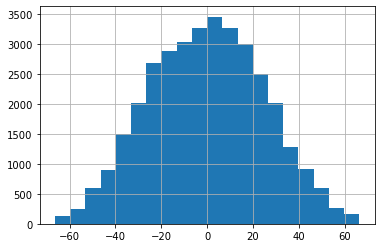

In [63]:
l_tempos = np.array(range(1,10)) * 5  # n trades
l_tempos = [50,]
for tN in l_tempos:
delta_price[tN] = base_entries.groupby(level=0)['avg_price'].shift(-tN) - base_entries['avg_price']
print(delta_price[tN].describe())
rng = 0.8*delta_price[tN].max()
delta_price[tN].hist(bins=20, range=(-rng, rng) )

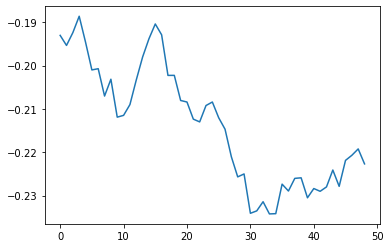

In [74]:
model = 'mw_up'
means = []
for tN in l_tempos:
df_bymodel = base_entries[tN].loc[base_entries[tN]['model']==model, 'delta_p']
means += [df_bymodel.mean()]
means = np.array(means)
import matplotlib.pyplot as plt
plt.plot(means)
plt.show()

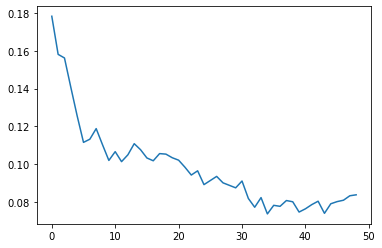

In [75]:
model = 'mw_down'
means = []
for tN in l_tempos:
df_bymodel = base_entries[tN].loc[base_entries[tN]['model']==model, 'delta_p']
means += [df_bymodel.mean()]
means = np.array(means)
import matplotlib.pyplot as plt
plt.plot(means)
plt.show()

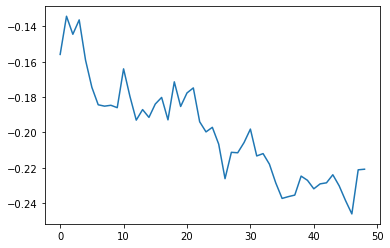

In [76]:
model = 'mi_up'
means = []
for tN in l_tempos:
df_bymodel = base_entries[tN].loc[base_entries[tN]['model']==model, 'delta_p']
means += [df_bymodel.mean()]
means = np.array(means)
import matplotlib.pyplot as plt
plt.plot(means)
plt.show()

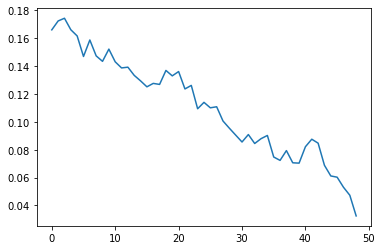

In [77]:
model = 'mi_down'
means = []
for tN in l_tempos:
df_bymodel = base_entries[tN].loc[base_entries[tN]['model']==model, 'delta_p']
means += [df_bymodel.mean()]
means = np.array(means)
import matplotlib.pyplot as plt
plt.plot(means)
plt.show()

In [78]:
d_th_prob[model]

0.5599999999999998

In [79]:
l_tempos = np.array(range(1,50)) * 5  # n trades
base_entries = {}
# l_tempos = [50,]
for tN in l_tempos:
base_main['delta_p'] = base_main.groupby(level=0)['avg_price'].shift(-tN) - base_main['avg_price']
base_entries[tN] = base_main.loc[:, ['model', 'prob', 'delta_p']]
# print(delta_price[tN].describe())
# rng = 0.8*delta_price[tN].max()
# delta_price[tN].hist(bins=20, range=(-rng, rng) )

In [80]:
# model = 'mi_down'
l_th = [0, 0.5, d_th_prob[model], d_th_prob[model]+0.1, d_th_prob[model]+0.2]
sums_th = []
for model in l_models:
for tN in l_tempos:
for f_th in l_th:
df_bymodel = base_entries[tN].loc[(base_entries[tN]['model']==model) & (base_entries[tN]['prob'] > f_th), 'delta_p']
sums_th.append([model, tN, f_th, df_bymodel.sum()])
df_sums = pd.DataFrame(sums_th, columns=['model', 'tN', 'th', 'sum'])

In [81]:
df_sums

model   tN    th       sum
0      mi_up    5 0.000 -2414.310
1      mi_up    5 0.500 -1149.266
2      mi_up    5 0.560    85.241
3      mi_up    5 0.660     1.500
4      mi_up    5 0.760     0.000
..       ...  ...   ...       ...
975  mw_down  245 0.000  3704.501
976  mw_down  245 0.500   358.590
977  mw_down  245 0.560  -378.912
978  mw_down  245 0.660     9.500
979  mw_down  245 0.760     0.000

[980 rows x 4 columns]

In [92]:
df_sums.pivot(columns='th')

KeyError: "None of ['th'] are in the columns"

In [93]:
df_sums.reset_index(inplace=True)

In [94]:
df_sums.pivot(columns='th')

model                                          tN                  \
th     0.000    0.500    0.560    0.660    0.760   0.000   0.500   0.560   
0      mi_up      NaN      NaN      NaN      NaN   5.000     nan     nan   
1        NaN    mi_up      NaN      NaN      NaN     nan   5.000     nan   
2        NaN      NaN    mi_up      NaN      NaN     nan     nan   5.000   
3        NaN      NaN      NaN    mi_up      NaN     nan     nan     nan   
4        NaN      NaN      NaN      NaN    mi_up     nan     nan     nan   
..       ...      ...      ...      ...      ...     ...     ...     ...   
975  mw_down      NaN      NaN      NaN      NaN 245.000     nan     nan   
976      NaN  mw_down      NaN      NaN      NaN     nan 245.000     nan   
977      NaN      NaN  mw_down      NaN      NaN     nan     nan 245.000   
978      NaN      NaN      NaN  mw_down      NaN     nan     nan     nan   
979      NaN      NaN      NaN      NaN  mw_down     nan     nan     nan   

                          sum                                 
th    0.660   0.760     0.000     0.500    0.560 0.660 0.760  
0       nan     nan -2414.310       nan      nan   nan   nan  
1       nan     nan       nan -1149.266      nan   nan   nan  
2       nan     nan       nan       nan   85.241   nan   nan  
3     5.000     nan       nan       nan      nan 1.500   nan  
4       nan   5.000       nan       nan      nan   nan 0.000  
..      ...     ...       ...       ...      ...   ...   ...  
975     nan     nan  3704.501       nan      nan   nan   nan  
976     nan     nan       nan   358.590      nan   nan   nan  
977     nan     nan       nan       nan -378.912   nan   nan  
978 245.000     nan       nan       nan      nan 9.500   nan  
979     nan 245.000       nan       nan      nan   nan 0.000  

[980 rows x 15 columns]

In [95]:
df_sums.pivot(index=['model','tN'], columns='th', values='sum')

th               0.000     0.500    0.560   0.660  0.760
model   tN                                              
mi_down 5     2552.528   835.261 -165.534  -0.500  0.000
        10    2650.177   765.237 -207.632   1.500  0.000
        15    2679.490   742.298 -263.186  -0.667  0.000
        20    2551.701   599.551 -287.985   0.000  0.000
        25    2482.552   314.907 -415.278  -1.750  0.000
...                ...       ...      ...     ...    ...
mw_up   225 -10030.334 -2885.716 -603.463 -12.157  0.000
        230  -9763.932 -2769.359 -585.143   2.410  0.000
        235  -9709.450 -2973.620 -707.878   8.785  0.000
        240  -9642.514 -2890.763 -728.783   0.026  0.000
        245  -9792.054 -2777.242 -597.200  25.712  0.000

[196 rows x 5 columns]

model
mi_down    AxesSubplot(0.125,0.125;0.775x0.755)
mi_up      AxesSubplot(0.125,0.125;0.775x0.755)
mw_down    AxesSubplot(0.125,0.125;0.775x0.755)
mw_up      AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

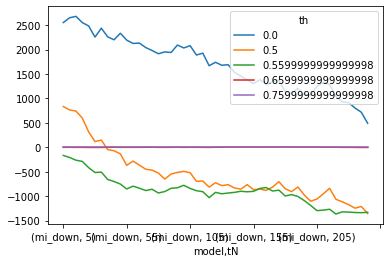

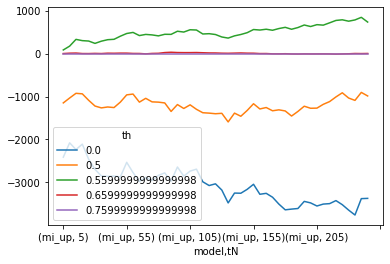

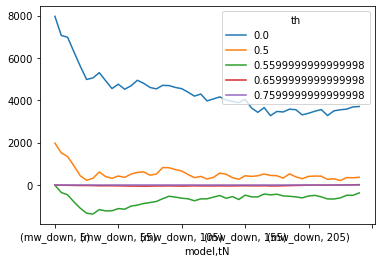

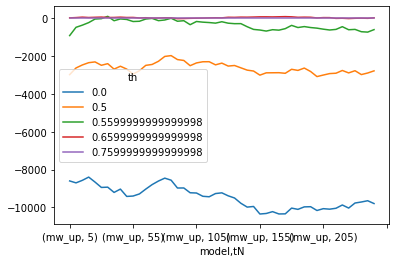

In [97]:
df_pivot.groupby(level=0).plot()

In [99]:
d_th_prob

{'mi_up': 0.5599999999999998,
 'mi_down': 0.5599999999999998,
 'mw_up': 0.5799999999999998,
 'mw_down': 0.5799999999999998,
 'md_up': 0.5,
 'md_down': 0.5}

In [100]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.56
model = 'mi_up'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tN]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, stop, gain):
if i == len(l_tempos):
return 0.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-stop)
pg = 1 - emp(gain)
pnl = ps * (-stop) + pg * (gain) + (1 - ps - pg) * exp_pnl(i + 1, stop, gain)
return pnl
# optimization
size = 20
best_pnl = -1E16
sg = np.zeros((size, size))
for stop in range(4, size):
for gain in range(4, size):
pnl_sg = exp_pnl(0, stop * .5, gain * .5)
sg[stop][gain] = pnl_sg
if pnl_sg > best_pnl:
best_stop = stop
best_gain = gain
best_pnl = pnl_sg
print('best stop/gain: {:.2f} / {:.2f}', -best_stop*.5, best_gain*.5)

best stop/gain: {:.2f} / {:.2f} -9.5 6.0


In [101]:
print('best stop/gain: {:.2f} / {:.2f}'.format(-best_stop*.5, best_gain*.5))

best stop/gain: -9.50 / 6.00


In [102]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.56
model = 'mi_up'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tN]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, stop, gain):
if i == len(l_tempos):
return 0.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-stop)
pg = 1 - emp(gain)
pnl = ps * (-stop) + pg * (gain) + (1 - ps - pg) * exp_pnl(i + 1, stop, gain)
return pnl
# optimization
size = 50
best_pnl = -1E16
sg = np.zeros((size, size))
for stop in range(4, size):
for gain in range(4, size):
pnl_sg = exp_pnl(0, stop * .5, gain * .5)
sg[stop][gain] = pnl_sg
if pnl_sg > best_pnl:
best_stop = stop
best_gain = gain
best_pnl = pnl_sg
print('best stop/gain: {:.2f} / {:.2f}'.format(-best_stop*.5, best_gain*.5))

best stop/gain: -24.50 / 9.00


In [103]:
sg

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 6.60116464, 6.73735146,
        6.88076   ],
       [0.        , 0.        , 0.        , ..., 6.59805409, 6.73423958,
        6.87764812],
       [0.        , 0.        , 0.        , ..., 6.61972361, 6.75594378,
        6.89937776]])

In [104]:
best_pnl

7.894610630713397

In [105]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.56
model = 'mi_up'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tN]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, stop, gain):
if i == len(l_tempos):
return 0.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-stop)
pg = 1 - emp(gain)
pnl = ps * (-stop) + pg * (gain) + (1 - ps - pg) * exp_pnl(i + 1, stop, gain)
return pnl
# optimization
size = 10
best_pnl = -1E16
sg = np.zeros((size, size))
for stop in range(2, size):
for gain in range(2, size):
pnl_sg = exp_pnl(0, stop * .5, gain * .5)
sg[stop][gain] = pnl_sg
if pnl_sg > best_pnl:
best_stop = stop
best_gain = gain
best_pnl = pnl_sg
print('best stop/gain: {:.2f} / {:.2f}'.format(-best_stop*.5, best_gain*.5))

best stop/gain: -4.50 / 2.50


In [106]:
2**4

16

In [108]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.56
model = 'mi_up'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tN]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, stop, gain):
if i == len(l_tempos):
return 0., 1.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-stop)
pg = 1 - emp(gain)
epnl, _ = exp_pnl(i + 1, stop, gain)
pnl = ps * (-stop) + pg * (gain) + (1 - ps - pg) * epnl
vol = np.sqrt(ps * (-stop - pnl)**2 + pg * (gain - pnl)**2 + (1 - ps - pg) * (epnl - pnl)**2)
return pnl, vol
# optimization
size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for stop in range(2, size):
for gain in range(2, size):
pnl_sg, vol_sg = exp_pnl(0, stop * .5, gain * .5)
sg[stop][gain] = pnl_sg
if pnl_sg/vol_sg > best_pnl:
best_stop = stop
best_gain = gain
best_pnl = pnl_sg
best_pnl_vol = pnl_sg/vol_sg
print('best stop/gain: {:.2f} / {:.2f}'.format(-best_stop*.5, best_gain*.5))
print('best pnl (over vol), pnl/vol: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol))

best stop/gain: -39.50 / 39.50
best pnl (over vol), pnl/vol: 11.21 , 13.61


In [109]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.56
model = 'mi_up'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tN]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, stop, gain):
if i == len(l_tempos):
return 0., 1.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-stop)
pg = 1 - emp(gain)
epnl, _ = exp_pnl(i + 1, stop, gain)
pnl = ps * (-stop) + pg * (gain) + (1 - ps - pg) * epnl
vol = np.sqrt(ps * (-stop - pnl)**2 + pg * (gain - pnl)**2 + (1 - ps - pg) * (epnl - pnl)**2)
return pnl, vol
# optimization
size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for stop in range(2, size):
for gain in range(2, size):
pnl_sg, vol_sg = exp_pnl(0, stop * .5, gain * .5)
sg[stop][gain] = pnl_sg
if pnl_sg/vol_sg > best_pnl_vol:
best_stop = stop
best_gain = gain
best_pnl = pnl_sg
best_pnl_vol = pnl_sg/vol_sg
print('best stop/gain: {:.2f} / {:.2f}'.format(-best_stop*.5, best_gain*.5))
print('best pnl (over vol), pnl/vol: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol))

best stop/gain: -28.50 / 1.00
best pnl (over vol), pnl/vol: 1.00 , 96705309242.71


In [110]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.56
model = 'mi_up'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tN]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, stop, gain):
if i == len(l_tempos):
return 0., 0.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-stop)
pg = 1 - emp(gain)
epnl, evol = exp_pnl(i + 1, stop, gain)
pnl = ps * (-stop) + pg * (gain) + (1 - ps - pg) * epnl
vol = np.sqrt(ps * (-stop - pnl)**2 + pg * (gain - pnl)**2 + (1 - ps - pg) * evol**2)
return pnl, vol
# optimization
size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for stop in range(2, size):
for gain in range(2, size):
pnl_sg, vol_sg = exp_pnl(0, stop * .5, gain * .5)
sg[stop][gain] = pnl_sg
if pnl_sg/vol_sg > best_pnl_vol:
best_stop = stop
best_gain = gain
best_pnl = pnl_sg
best_pnl_vol = pnl_sg/vol_sg
print('best stop/gain: {:.2f} / {:.2f}'.format(-best_stop*.5, best_gain*.5))
print('best pnl (over vol), pnl/vol: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol))

best stop/gain: -28.50 / 1.00
best pnl (over vol), pnl/vol: 1.00 , 240844.03


In [111]:
pd.DataFrame(sg)

0     1      2      3      4      5      6      7      8      9      10  \
0  0.000 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1  0.000 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2  0.000 0.000 -0.162 -0.215 -0.306 -0.411 -0.529 -0.635 -0.733 -0.799 -0.838   
3  0.000 0.000 -0.141 -0.204 -0.325 -0.475 -0.654 -0.817 -0.975 -1.093 -1.170   
4  0.000 0.000 -0.036 -0.087 -0.218 -0.401 -0.634 -0.857 -1.080 -1.262 -1.393   
..   ...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
75 0.000 0.000  1.000  1.500  2.000  2.500  3.000  3.500  4.000  4.499  4.998   
76 0.000 0.000  1.000  1.500  2.000  2.500  3.000  3.500  4.000  4.499  4.998   
77 0.000 0.000  1.000  1.500  2.000  2.500  3.000  3.500  4.000  4.499  4.998   
78 0.000 0.000  1.000  1.500  2.000  2.500  3.000  3.500  4.000  4.499  4.998   
79 0.000 0.000  1.000  1.500  2.000  2.500  3.000  3.500  4.000  4.499  4.998   

       11     12     13     14     15     16     17     18     19     20  \
0   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2  -0.875 -0.894 -0.911 -0.920 -0.929 -0.931 -0.934 -0.934 -0.932 -0.930   
3  -1.242 -1.285 -1.320 -1.343 -1.366 -1.375 -1.387 -1.389 -1.389 -1.387   
4  -1.517 -1.597 -1.662 -1.708 -1.758 -1.783 -1.809 -1.817 -1.824 -1.824   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
75  5.492  5.978  6.445  6.881  7.264  7.580  7.808  7.943  7.941  7.813   
76  5.492  5.978  6.445  6.881  7.264  7.580  7.808  7.943  7.941  7.813   
77  5.492  5.978  6.445  6.881  7.264  7.580  7.808  7.943  7.941  7.813   
78  5.492  5.978  6.445  6.881  7.264  7.580  7.808  7.943  7.941  7.813   
79  5.492  5.978  6.445  6.881  7.264  7.580  7.808  7.943  7.941  7.813   

       21     22     23     24     25     26     27     28     29     30  \
0   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2  -0.933 -0.930 -0.928 -0.925 -0.927 -0.924 -0.921 -0.919 -0.916 -0.913   
3  -1.391 -1.387 -1.383 -1.379 -1.382 -1.378 -1.374 -1.369 -1.365 -1.361   
4  -1.830 -1.826 -1.821 -1.815 -1.819 -1.813 -1.807 -1.801 -1.794 -1.788   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
75  7.584  7.327  7.077  6.845  6.587  6.346  6.080  5.950  5.782  5.697   
76  7.584  7.327  7.077  6.845  6.587  6.346  6.080  5.950  5.782  5.697   
77  7.584  7.327  7.077  6.845  6.587  6.346  6.080  5.950  5.782  5.697   
78  7.584  7.327  7.077  6.845  6.587  6.346  6.080  5.950  5.782  5.697   
79  7.584  7.327  7.077  6.845  6.587  6.346  6.080  5.950  5.782  5.697   

       31     32     33     34     35     36     37     38     39     40  \
0   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2  -0.912 -0.909 -0.907 -0.904 -0.903 -0.901 -0.898 -0.896 -0.893 -0.890   
3  -1.359 -1.355 -1.351 -1.347 -1.346 -1.342 -1.338 -1.334 -1.330 -1.326   
4  -1.786 -1.780 -1.773 -1.767 -1.766 -1.760 -1.754 -1.748 -1.742 -1.736   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
75  5.566  5.441  5.417  5.378  5.381  5.416  5.500  5.620  5.756  5.855   
76  5.566  5.441  5.417  5.378  5.381  5.416  5.500  5.620  5.756  5.855   
77  5.566  5.441  5.417  5.378  5.381  5.416  5.500  5.620  5.756  5.855   
78  5.566  5.441  5.417  5.378  5.381  5.416  5.500  5.620  5.756  5.855   
79  5.566  5.441  5.417  5.378  5.381  5.416  5.500  5.620  5.756  5.855   

       41     42     43     44     45     46     47     48     49     50  \
0   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2  -0.888 -0.885 -0.883 -0.880 -0.877 -0.875 -0.872 -0.870 -0.867 

<AxesSubplot:>

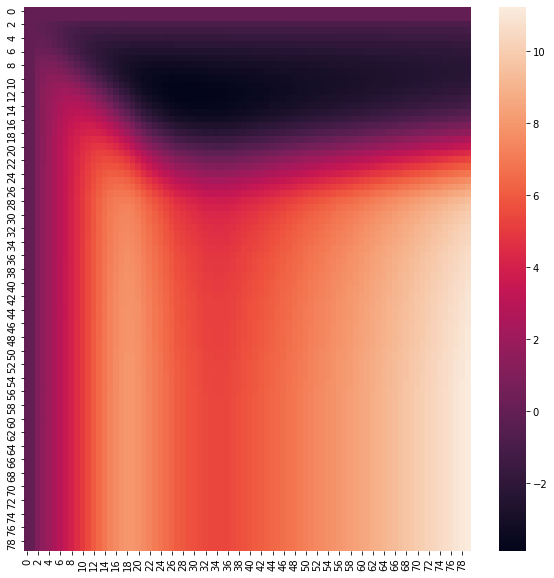

In [114]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(sg), ax=ax)

In [115]:
l_tempos = np.array(range(1,100)) * 5  # n trades
base_entries = {}
for tN in l_tempos:
base_main['delta_p'] = base_main.groupby(level=0)['avg_price'].shift(-tN) - base_main['avg_price']
base_entries[tN] = base_main.loc[:, ['model', 'prob', 'delta_p']]
# print(delta_price[tN].describe())
# rng = 0.8*delta_price[tN].max()
# delta_price[tN].hist(bins=20, range=(-rng, rng) )

model
mi_down    AxesSubplot(0.125,0.125;0.775x0.755)
mi_up      AxesSubplot(0.125,0.125;0.775x0.755)
mw_down    AxesSubplot(0.125,0.125;0.775x0.755)
mw_up      AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

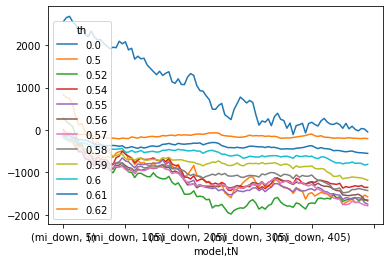

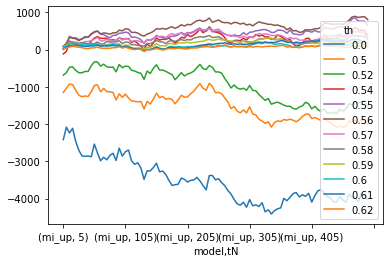

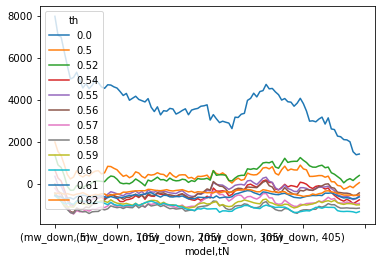

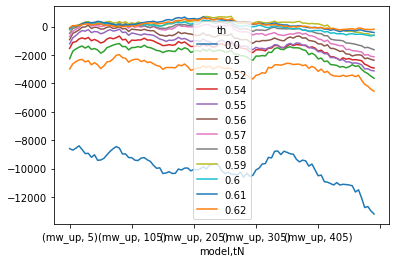

In [117]:
df_pivot.groupby(level=0).plot()

In [124]:
# optimizing STOP/GAIN/VOL/DRAWDOWN
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.56
model = 'mi_up'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tn]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, linf, lsup):
if i == len(l_tempos):
return 0., 0.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-linf)
pg = 1 - emp(lsup)
epnl, evol = exp_pnl(i + 1, linf, lsup)
pnl = ps * (-linf) + pg * (lsup) + (1 - ps - pg) * epnl
vol = np.sqrt(ps * (-linf - pnl)**2 + pg * (lsup - pnl)**2 + (1 - ps - pg) * evol**2)
return pnl, vol
size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
for lsup in range(4, size):
pnl_sg, vol_sg = exp_pnl(0, linf * .5, lsup * .5)
if model in ['mi_up', 'mw_up']:
stop = linf
else:
stop = lsup
pnl_sg = -pnl_sg
sg[linf][lsup] = pnl_sg
if (pnl_sg/stop) > best_pnl_vol:
best_linf = linf
best_lsup = lsup
best_pnl = pnl_sg
best_pnl_vol = pnl_sg/stop
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol))

best linf/lsup: -18.50 / 39.50
best pnl (over risk), pnl/risk: 22.49 , 0.61


<AxesSubplot:>

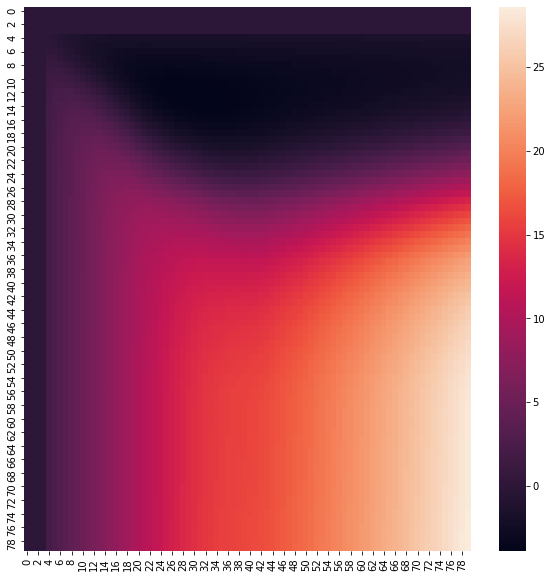

In [125]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mi_down 
best linf/lsup: -5.00 / 7.50
best pnl (over risk), pnl/risk: 3.28 , 0.44


<AxesSubplot:>

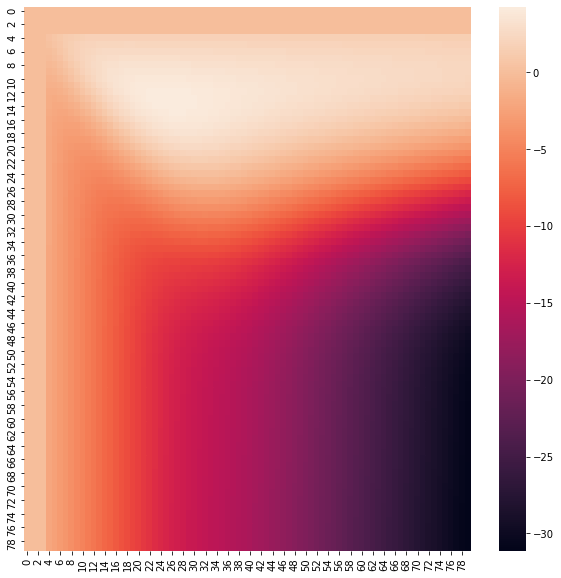

In [127]:
# optimizing STOP/GAIN/VOL/DRAWDOWN
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.52
model = 'mi_down'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tn]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, linf, lsup):
if i == len(l_tempos):
return 0., 0.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-linf)
pg = 1 - emp(lsup)
epnl, evol = exp_pnl(i + 1, linf, lsup)
pnl = ps * (-linf) + pg * (lsup) + (1 - ps - pg) * epnl
vol = np.sqrt(ps * (-linf - pnl)**2 + pg * (lsup - pnl)**2 + (1 - ps - pg) * evol**2)
return pnl, vol
size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
for lsup in range(4, size):
pnl_sg, vol_sg = exp_pnl(0, linf * .5, lsup * .5)
if model in ['mi_up', 'mw_up']:
stop = linf
else:
stop = lsup
pnl_sg = -pnl_sg
sg[linf][lsup] = pnl_sg
if (pnl_sg/stop) > best_pnl_vol:
best_linf = linf
best_lsup = lsup
best_pnl = pnl_sg
best_pnl_vol = pnl_sg/stop
print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mw_down 
best linf/lsup: -4.00 / 7.50
best pnl (over risk), pnl/risk: 2.93 , 0.39


<AxesSubplot:>

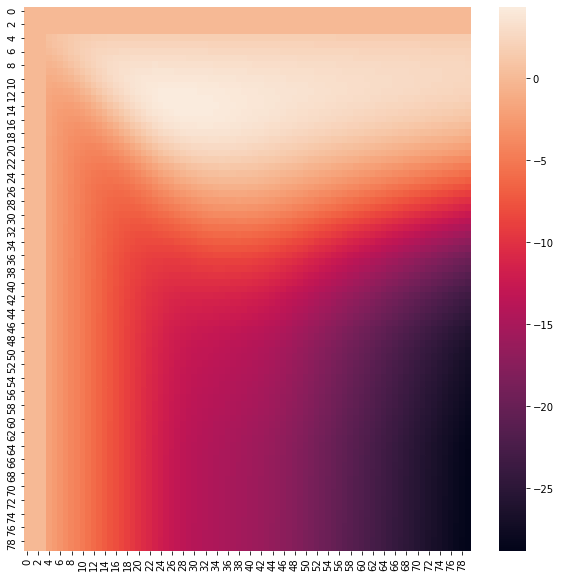

In [128]:
# optimizing STOP/GAIN/VOL/DRAWDOWN
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.6
model = 'mw_down'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tn]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, linf, lsup):
if i == len(l_tempos):
return 0., 0.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-linf)
pg = 1 - emp(lsup)
epnl, evol = exp_pnl(i + 1, linf, lsup)
pnl = ps * (-linf) + pg * (lsup) + (1 - ps - pg) * epnl
vol = np.sqrt(ps * (-linf - pnl)**2 + pg * (lsup - pnl)**2 + (1 - ps - pg) * evol**2)
return pnl, vol
size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
for lsup in range(4, size):
pnl_sg, vol_sg = exp_pnl(0, linf * .5, lsup * .5)
if model in ['mi_up', 'mw_up']:
stop = linf
else:
stop = lsup
pnl_sg = -pnl_sg
sg[linf][lsup] = pnl_sg
if (pnl_sg/stop) > best_pnl_vol:
best_linf = linf
best_lsup = lsup
best_pnl = pnl_sg
best_pnl_vol = pnl_sg/stop
print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(sg), ax=ax)

Model: mw_up 
best linf/lsup: -20.50 / 39.50
best pnl (over risk), pnl/risk: 24.40 , 1.19


<AxesSubplot:>

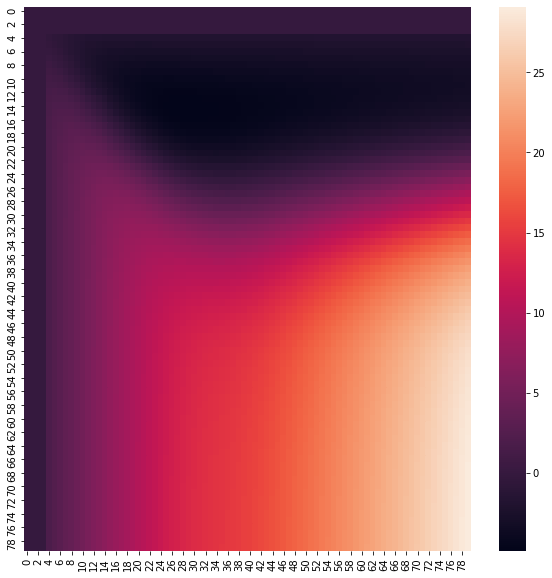

In [129]:
# optimizing STOP/GAIN/VOL/DRAWDOWN
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
delta_prices = {}
th = 0.58
model = 'mw_up'
for tn in l_tempos:
delta_prices[tn] = base_entries[tn].loc[(base_entries[tn]['model']==model) & (base_entries[tn]['prob'] > th), 'delta_p']
# expected P&L for given stop, gain
def exp_pnl(i, linf, lsup):
if i == len(l_tempos):
return 0., 0.
delta_p = delta_prices[l_tempos[i]]
emp = ECDF(delta_p)
ps = emp(-linf)
pg = 1 - emp(lsup)
epnl, evol = exp_pnl(i + 1, linf, lsup)
pnl = ps * (-linf) + pg * (lsup) + (1 - ps - pg) * epnl
vol = np.sqrt(ps * (-linf - pnl)**2 + pg * (lsup - pnl)**2 + (1 - ps - pg) * evol**2)
return pnl, vol
size = 80
best_pnl = -1E16
best_pnl_vol = -1E16
sg = np.zeros((size, size))
for linf in range(4, size):
for lsup in range(4, size):
pnl_sg, vol_sg = exp_pnl(0, linf * .5, lsup * .5)
if model in ['mi_up', 'mw_up']:
stop = linf
else:
stop = lsup
pnl_sg = -pnl_sg
sg[linf][lsup] = pnl_sg
if (pnl_sg/stop) > best_pnl_vol:
best_linf = linf
best_lsup = lsup
best_pnl = pnl_sg
best_pnl_vol = pnl_sg/stop
print('Model: {} '.format(model))
print('best linf/lsup: {:.2f} / {:.2f}'.format(-best_linf*.5, best_lsup*.5))
print('best pnl (over risk), pnl/risk: {:.2f} , {:.2f}'.format(best_pnl, best_pnl_vol/.5))
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(sg), ax=ax)